# Learning to optimize parametric nonlinear programming problem (pNLP) using Neuromancer

This is an interactive notebook based on the python script [Part_1_LearnToOptimize_tutorial.py](./Part_1_LearnToOptimize_tutorial.py).  

We will demonstrate the capability of learning to optimize (L2O)
for solving [parametric nonlinear programming problem (pNLP)](https://en.wikipedia.org/wiki/Parametric_programming) defined as:

$$
\begin{align}
&\text{minimize } &&  f(x, \theta) \\
&\text{subject to} && g(x, \theta) \le 0
\end{align}
$$

with  parameters $\theta$ and decision variables $x$.

In L2O train a neural network mapping problem parameters onto the primal decision variables $x = \pi(\theta)$ by using gradients of the optimizaiton problem to minimize the objective function and satisfy the constraints.

### References
[1] [F. Fioretto, et al., Predicting AC Optimal Power Flows: Combining Deep Learning and Lagrangian Dual Methods, 2019](https://arxiv.org/abs/1909.10461)  
[2] [S. Gould, et al., Deep Declarative Networks: A New Hope, 2020](https://arxiv.org/abs/1909.04866)  
[3] [P. Donti, et al., DC3: A learning method for optimization with hard constraints, 2021](https://arxiv.org/abs/2104.12225)  
[4] [J. Kotary, et al., End-to-End Constrained Optimization Learning: A Survey, 2021](https://arxiv.org/abs/2103.16378)  
[5] [M. Li, et al., Learning to Solve Optimization Problems with Hard Linear Constraints, 2022](https://arxiv.org/abs/2208.10611)  
[6] [R. Sambharya, et al., End-to-End Learning to Warm-Start for Real-Time Quadratic Optimization, 2022](https://arxiv.org/abs/2212.08260)  

- https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/parametric_programming/Part_1_basics.ipynb

### Import

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import casadi
import time

In [ ]:
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

# Problem formulation

In this example we will solve parametric constrained [Rosenbrock problem](https://en.wikipedia.org/wiki/Rosenbrock_function):

$$
\begin{align}
&\text{minimize } &&  (1-x)^2 + a(y-x^2)^2\\
&\text{subject to} && \left(\frac{p}{2}\right)^2 \le x^2 + y^2 \le p^2\\
& && x \ge y
\end{align}
$$

with parameters $p, a$ and decision variables $x, y$.


## Dataset

We construct the dataset by sampling the parametric space.

In [ ]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed);

Randomly sample parameters from a uniform distribution: $0.5\le p\le2.0$;  $0.2\le a\le1.2$

In [ ]:
nsim = 5000  # number of datapoints: increase sample density for more robust results

# create dictionaries with sampled datapoints with uniform distribution
a_low, a_high, p_low, p_high = 0.2, 1.2, 0.5, 2.0
samples_train = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
                 "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev   = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
                 "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test  = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
                 "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data   = DictDataset(samples_dev  , name='dev')
test_data  = DictDataset(samples_test , name='test')

# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader   = torch.utils.data.DataLoader(dev_data  , batch_size=32, num_workers=0,
                                           collate_fn=dev_data.collate_fn  , shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data , batch_size=32, num_workers=0,
                                           collate_fn=test_data.collate_fn , shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

(5000, 1)


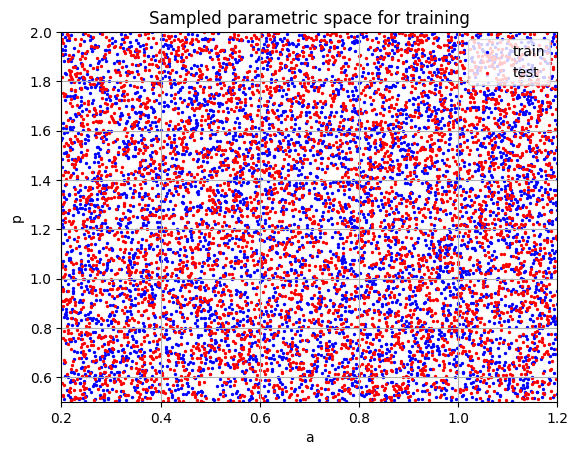

In [ ]:
# visualize taining and test samples for 2D parametric space
a_train = samples_train['a'].numpy()
p_train = samples_train['p'].numpy()
a_dev = samples_dev['a'].numpy()
p_dev = samples_dev['p'].numpy()
print(a_train.shape)

plt.figure()
plt.scatter(a_train, p_train, s=2., c='blue', marker='o')
plt.scatter(a_dev, p_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(a_low, a_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('a')
plt.ylabel('p')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)

## Primal Solution Map Architecture

A neural network mapping problem parameters onto primal decision variables:  
$$x = \pi(\theta)$$

In [ ]:
# define neural architecture for the trainable solution map
func = blocks.MLP(insize=2, outsize=2,
                  bias=True,
                  linear_map=slim.maps['linear'],
                  nonlin=nn.ReLU,
                  hsizes=[80] * 4)
# wrap neural net into symbolic representation of the solution map via the Node class: sol_map(xi) -> x
sol_map = Node(func, ['a', 'p'], ['x'], name='map')

## Objective and Constraints in NeuroMANCER

In [ ]:
"""
variable is a basic symbolic abstraction in Neuromancer
   x = variable("variable_name")                      (instantiates new variable)  
variable construction supports:
   algebraic expressions:     x**2 + x**3 + 5     (instantiates new variable)  
   slicing:                   x[:, i]             (instantiates new variable)  
   pytorch callables:         torch.sin(x)        (instantiates new variable)  
   constraints definition:    x <= 1.0            (instantiates Constraint object) 
   objective definition:      x.minimize()        (instantiates Objective object) 
to visualize computational graph of the variable use x.show() method          
"""

# define decision variables
x1 = variable("x")[:, [0]]
x2 = variable("x")[:, [1]]
# problem parameters sampled in the dataset
p = variable('p')
a = variable('a')

# objective function
f = (1-x1)**2 + a*(x2-x1**2)**2
obj = f.minimize(weight=1.0, name='obj')

# constraints
Q_con = 100.  # constraint penalty weights
con_1 = Q_con*(x1 >= x2)
con_2 = Q_con*((p/2)**2 <= x1**2+x2**2)
con_3 = Q_con*(x1**2+x2**2 <= p**2)
con_1.name = 'c1'
con_2.name = 'c2'
con_3.name = 'c3'

In [ ]:
# constrained optimization problem construction
objectives = [obj]
constraints = [con_1, con_2, con_3]
components = [sol_map]

# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)

# construct constrained optimization problem
problem = Problem(components, loss)

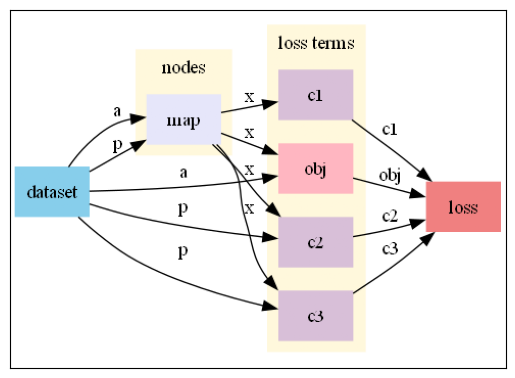

In [ ]:
problem.show()

## Parametric Problem Solution in NeuroMANCER

In [ ]:
lr = 0.001      # step size for gradient descent
epochs = 400    # number of training epochs
warmup = 100    # number of epochs to wait before enacting early stopping policy
patience = 100  # number of epochs with no improvement in eval metric to allow before early stopping

In [ ]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup
)

In [ ]:
# Train pNLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 3.3431477546691895
epoch: 1  train_loss: 0.29509055614471436
epoch: 2  train_loss: 0.12004771828651428
epoch: 3  train_loss: 0.09695009887218475
epoch: 4  train_loss: 0.10390645265579224
epoch: 5  train_loss: 0.08398374915122986
epoch: 6  train_loss: 0.10284885764122009
epoch: 7  train_loss: 0.09823866188526154
epoch: 8  train_loss: 0.07910480350255966
epoch: 9  train_loss: 0.07298458367586136
epoch: 10  train_loss: 0.11471041291952133
epoch: 11  train_loss: 0.08374916017055511
epoch: 12  train_loss: 0.08673328906297684
epoch: 13  train_loss: 0.07685934007167816
epoch: 14  train_loss: 0.0749950259923935
epoch: 15  train_loss: 0.0907716378569603
epoch: 16  train_loss: 0.09823688864707947
epoch: 17  train_loss: 0.09505365788936615
epoch: 18  train_loss: 0.10836701840162277
epoch: 19  train_loss: 0.0808413103222847
epoch: 20  train_loss: 0.08347771316766739
epoch: 21  train_loss: 0.08897767961025238
epoch: 22  train_loss: 0.07239869236946106
epoch: 23  train_loss: 0.

<All keys matched successfully>

## Get pNLP solution from trained neural network

In [ ]:
# selected problem parameters
p = 1.0
a = 1.0

In [ ]:
# Solution to pNLP via Neuromancer
datapoint = {'a': torch.tensor([[a]]), 'p': torch.tensor([[p]]),
             'name': 'test'}
model_out = problem(datapoint)
model_out

{'test_a': tensor([[1.]]),
 'test_p': tensor([[1.]]),
 'test_name': 'test',
 'test_x': tensor([[0.7818, 0.5272]], grad_fn=<AddmmBackward0>),
 'test_2111625683888': 1,
 'test_2111628177664': 2,
 'test_2111628755632': 2,
 'test_2111628757072': 2,
 'test_2111628357504': tensor([[0.7818]], grad_fn=<IndexBackward0>),
 'test_2111625680048': tensor([[0.5272]], grad_fn=<IndexBackward0>),
 'test_2111628355344': tensor([[0.2182]], grad_fn=<RsubBackward1>),
 'test_2111625680624': tensor([[0.6112]], grad_fn=<PowBackward0>),
 'test_2111625683456': tensor([[0.0476]], grad_fn=<PowBackward0>),
 'test_2111625681152': tensor([[-0.0840]], grad_fn=<SubBackward0>),
 'test_2111628179968': tensor([[0.0070]], grad_fn=<PowBackward0>),
 'test_2111626071008': tensor([[0.0070]], grad_fn=<MulBackward0>),
 'test_2111628755584': tensor([[0.0547]], grad_fn=<AddBackward0>),
 'test_2111628755584_<built-in method mean of type object>': tensor(0.0547, grad_fn=<MulBackward0>),
 'test_objective_loss': tensor(0.0547, grad_f

In [ ]:
model_out['test_' + "x"]

tensor([[0.7818, 0.5272]], grad_fn=<AddmmBackward0>)

In [ ]:
x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
print(x_nm)
print(y_nm)

0.7817657
0.52720433


## Get pNLP solution from CasADi for comparison

[CasADi](https://web.casadi.org/) is an open-source tool for constrained optimization and optimal control that has influenced the development of NeuroMANCER.

In [ ]:
# instantiate casadi optimizaiton problem class
def NLP_param(a, p, opti_silent=False):
    opti = casadi.Opti()
    # define variables
    x = opti.variable()
    y = opti.variable()
    p_opti = opti.parameter()
    a_opti = opti.parameter()
    # define objective and constraints
    opti.minimize((1 - x) ** 2 + a_opti * (y - x ** 2) ** 2)
    opti.subject_to(x >= y)
    opti.subject_to((p_opti / 2) ** 2 <= x ** 2 + y ** 2)
    opti.subject_to(x ** 2 + y ** 2 <= p_opti ** 2)
    # select IPOPT solver and solve the NLP
    if opti_silent:
        opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
    else:
        opts = {}
    opti.solver('ipopt', opts)
    # set parametric values
    opti.set_value(p_opti, p)
    opti.set_value(a_opti, a)
    return opti, x, y

# construct casadi problem
opti, x, y = NLP_param(a, p)
# solve NLP via casadi
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [ ]:
print(f"x = {sol.value(x)}")
print(f"y = {sol.value(y)}")

x = 0.8081695826847699
y = 0.588949838491767


## Compare: NeuroMANCER vs. CasADi

0.7817657
0.52720433


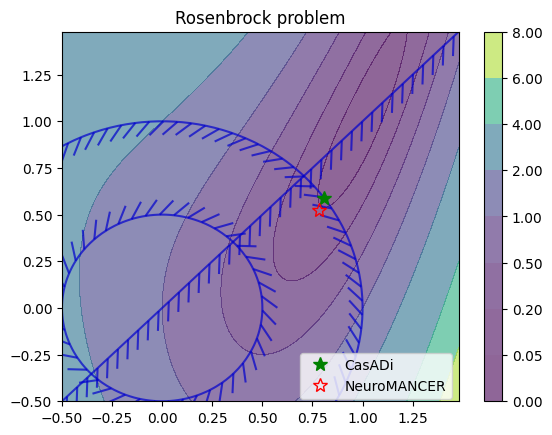

In [ ]:
"""
Plots
"""
x1 = np.arange(-0.5, 1.5, 0.02)
y1 = np.arange(-0.5, 1.5, 0.02)
xx, yy = np.meshgrid(x1, y1)

# eval objective and constraints
J = (1 - xx) ** 2 + a * (yy - xx ** 2) ** 2
c1 = xx - yy
c2 = xx ** 2 + yy ** 2 - (p / 2) ** 2
c3 = -(xx ** 2 + yy ** 2) + p ** 2

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(xx, yy, J,
                 levels=[0, 0.05, 0.2, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0],
                 alpha=0.6)
fig.colorbar(cp)
ax.set_title('Rosenbrock problem')
cg1 = ax.contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
cg1.set(path_effects=[patheffects.withTickedStroke()], alpha=0.7)
cg2 = ax.contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
cg2.set(path_effects=[patheffects.withTickedStroke()], alpha=0.7)
cg3 = ax.contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
cg3.set(path_effects=[patheffects.withTickedStroke()], alpha=0.7)
# Solution to mpNLP via Neuromancer
datapoint = {'a': torch.tensor([[a]]), 'p': torch.tensor([[p]]),
             'name': 'test'}
model_out = problem(datapoint)
x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
print(x_nm)
print(y_nm)

# plot optimal solutions CasADi vs Neuromancer
ax.plot(sol.value(x), sol.value(y), 'g*', markersize=10, label='CasADi')
ax.plot(x_nm, y_nm, 'r*', fillstyle='none', markersize=10, label='NeuroMANCER')
plt.legend(bbox_to_anchor=(1.0, 0.15))
plt.show(block=True)

In [ ]:
def eval_constraints(x, y, p):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, y - x)
    con_2_viol = np.maximum(0, (p/2)**2 - (x**2+y**2))
    con_3_viol = np.maximum(0, x**2+y**2 - p**2)
    con_viol = con_1_viol + con_2_viol + con_3_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean

def eval_objective(x, y):
    obj_value_mean = np.mean((1 - x) ** 2 + a * (y - x ** 2) ** 2)   
    return obj_value_mean

# select n number of random samples to evaluate
n_samples = 1000
idx = np.random.randint(0, nsim, n_samples)
p_samples = samples_test['p'][idx]
a_samples = samples_test['a'][idx]

In [ ]:
# create named dictionary for neuromancer
datapoint = {'a': a_samples, 'p': p_samples, 'name': 'test'}

# Solve via neuromancer
t = time.time()
model_out = problem(datapoint)
nm_time = time.time() - t
x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()

In [ ]:
# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, n_samples):
    prob, x, y = NLP_param(p_samples[i].numpy(), a_samples[i].numpy(), opti_silent=True)
    sol = prob.solve()
    x_solver.append(sol.value(x))
    y_solver.append(sol.value(y))
solver_time = time.time() - t
x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)

In [ ]:
# Evaluate neuromancer solution
print(f'Solution for {n_samples} problems via Neuromancer obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p)
print(f'Neuromancer mean constraints violation {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'Neuromancer mean objective value {nm_obj_mean:.4f}\n')

# Evaluate solver solution
print(f'Solution for {n_samples} problems via solver obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p)
print(f'Solver mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'Solver mean objective value {solver_obj_mean:.4f}\n')

# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')

Solution for 1000 problems via Neuromancer obtained in 0.0028 seconds
Neuromancer mean constraints violation 0.4050
Neuromancer mean objective value 0.0611

Solution for 1000 problems via solver obtained in 5.2272 seconds
Solver mean constraints violation 0.0746
Solver mean objective value 0.2036

Solution speedup factor 1868.9235
MSE primal optimizers: 0.12349015328656536
mean objective value discrepancy: 70.01 %
